In [213]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd
from scipy.signal import welch
from sklearn.decomposition import FastICA
import mne
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)

(23700, 32)
Creating RawArray with float64 data, n_channels=32, n_times=23700
    Range : 0 ... 23699 =      0.000 ...    46.287 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


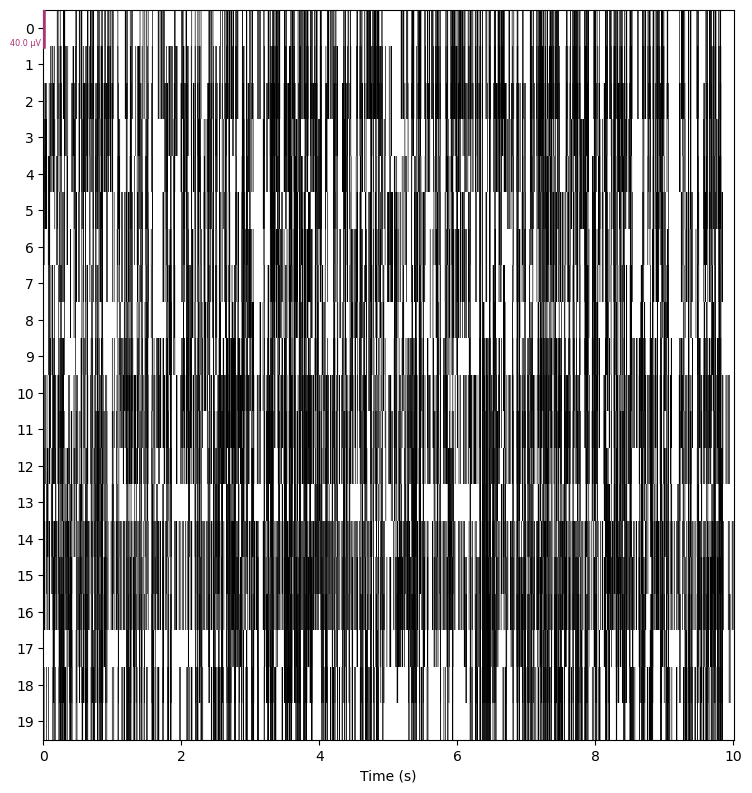

In [214]:
# get sample data
df = pd.read_csv('./datasets/bi2015a/subject_01_session_01.csv', header=None)
#df = pd.read_csv('./datasets/bi2014b/group_01_sujet_01.csv', header=None)
X_train = df.iloc[15300:39000, 1:33].values
print(X_train.shape)

headerNames = pd.read_csv('./datasets/bi2015a/Header.csv', header=None)
headerNames = list(headerNames.iloc[0])
X_train = mne.io.RawArray(X_train.T, mne.create_info(32, 512, 'eeg'))
X_train.filter(0.5, 40, fir_design='firwin')
#X_train.plot_sensors(ch_type='eeg', kind='topomap', show_names=True)
#X_train.ch_names
X_train.plot(show_scrollbars=False);

In [215]:
X_train_filted = X_train.copy()
#X_train_filted.filter(1, None, fir_design='firwin')
n_cmp = 32
ica = ICA(n_components=n_cmp, max_iter='auto', random_state=42, method='infomax')
ica.fit(X_train_filted)
ica

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
 
Fitting ICA took 4.2s.


Method,infomax
Fit,500 iterations on raw data (23700 samples)
ICA components,32
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [216]:
explained_var_ratio = ica.get_explained_variance_ratio(X_train_filted)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f'Fraction of {channel_type} variance explained by all components: '
        f'{ratio}'
    )

Fraction of eeg variance explained by all components: 1.0


In [217]:
for i in range(n_cmp): 
    explained_var_ratio = ica.get_explained_variance_ratio(
        X_train_filted,
        components=[i],
        ch_type='eeg'
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio['eeg'])
    print(
        f'{i}  Fraction of variance in EEG signal explained by first component: '
        f'{ratio_percent}%'
    )

0  Fraction of variance in EEG signal explained by first component: 89%
1  Fraction of variance in EEG signal explained by first component: 7%
2  Fraction of variance in EEG signal explained by first component: 6%
3  Fraction of variance in EEG signal explained by first component: 4%
4  Fraction of variance in EEG signal explained by first component: 3%
5  Fraction of variance in EEG signal explained by first component: 3%
6  Fraction of variance in EEG signal explained by first component: 4%
7  Fraction of variance in EEG signal explained by first component: 3%
8  Fraction of variance in EEG signal explained by first component: 3%
9  Fraction of variance in EEG signal explained by first component: 3%
10  Fraction of variance in EEG signal explained by first component: 3%
11  Fraction of variance in EEG signal explained by first component: 3%
12  Fraction of variance in EEG signal explained by first component: 3%
13  Fraction of variance in EEG signal explained by first component: 3%
1

Creating RawArray with float64 data, n_channels=32, n_times=23700
    Range : 0 ... 23699 =      0.000 ...    46.287 secs
Ready.


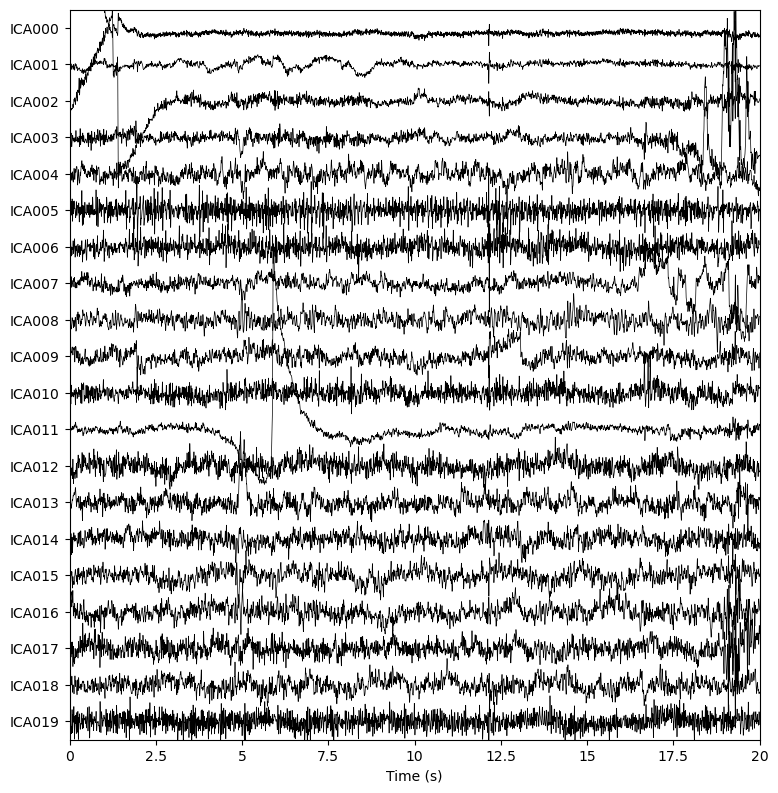

In [218]:
X_train.load_data()
ica.plot_sources(X_train, show_scrollbars=False);